In [23]:
import pandas as pd
import seaborn as sns
import numpy as np

In [24]:
# # old stuff

# df1 = pd.read_csv('classification_real_data_ds0_7_rs10.csv')

# df2 = pd.read_csv('classification_real_data_2021-Apr-10-16:09:22.csv')

# df3 = pd.concat([df1, df2])

# df3.to_csv('classification_real_data_ds0_9_rs10.csv',index = False)
# df2.data_split.unique()

In [52]:
df = pd.read_csv('classification_real_data_ds0_9_rs10_small.csv')

In [26]:
original_cols = df.columns.tolist()
original_shape = df.shape; original_shape

(256500, 14)

In [27]:
# add global metric minima column - init_mse_test
# idx == key, 
# cols - idx == cols to add
cols = ['dataset', 'random_state', 'data_split', 'model', 'imp_type', 'mse_test']
idx = ['dataset', 'random_state', 'data_split', 'model', 'imp_type']

init_metric = df.query('dropped_feature == "full_set"')
init_metric = init_metric.groupby(idx).mse_test.max()
init_metric = init_metric.rename('init_mse_test')

# merge into original df
df_full = pd.merge(df, init_metric, on=idx, how='inner')
original_shape, df_full.shape

((256500, 14), (256500, 15))

In [28]:
# add columns related to {max, curr} feature counts, feature_count relative percentages
# idx == key 
# cols - idx == cols to add

cols = ['dataset', 'iteration']
idx = ['dataset']
max_feature_cnt = df[cols]
max_feature_cnt = max_feature_cnt.groupby(idx).max() + 1

max_feature_cnt['f_cnt_10perc'] = np.round((max_feature_cnt.iteration * 0.1)).astype(int)
max_feature_cnt['f_cnt_20perc'] = np.round((max_feature_cnt.iteration * 0.2)).astype(int)
max_feature_cnt['f_cnt_30perc'] = np.round((max_feature_cnt.iteration * 0.3)).astype(int)
max_feature_cnt = max_feature_cnt.rename(columns={'iteration':'max_feature_cnt'})

# merge into original df
df_full = pd.merge(df_full, max_feature_cnt, on=idx, how='inner')
original_shape, df_full.shape

((256500, 14), (256500, 19))

In [29]:
df_full['mse_delta'] = df_full.mse_test - df_full.init_mse_test
df_full['mse_perc'] = df_full.mse_delta / df_full.init_mse_test
df_full['feature_cnt'] = df_full.max_feature_cnt - df_full.iteration
df_full['pp_coef'] =  df_full.mse_test / df_full.init_mse_test
# df_full['pp_coef'] = df_full.init_mse_test / df_full.mse_test

# max_perc grouping
grouping = ['dataset', 'random_state', 'data_split', 'model', 'imp_type']

# select all non-base models
max_perc = df_full.query('iteration > 0')
max_perc = max_perc.groupby(grouping).mse_perc.max()
max_perc = max_perc.rename('max_perc')

df_full = pd.merge(df_full, max_perc, on=grouping, how='inner')
original_shape, df_full.shape

((256500, 14), (256500, 24))

In [30]:
# grouping = ['dataset', 'random_state', 'data_split', 'model', 'imp_type']

# max_perc = df_full.query('iteration > 0')
# max_perc = max_perc.groupby(grouping).mse_perc.max()
# max_perc = max_perc.rename('max_perc')

# df_full = df_full.join(max_perc, on=grouping)

In [31]:
df_full['feature_dropped'] =  df_full.max_feature_cnt - df_full.feature_cnt
df_full['feature_dropped_perc'] = (1 - (df_full.max_feature_cnt - df_full.feature_dropped) 
                                   / df_full.max_feature_cnt)

In [32]:
repr_lst = ['iteration'] + df_full.columns[5:].to_list()

In [33]:
df_res = df_full[repr_lst]

In [34]:
# Case1: Can we get a metric improvement
# Case2: No decrease in metric
# Case3: Maximum interpretability (use [0.1, 0.2, 0.3] of all features)

In [35]:
ordering = ['iteration', 'mse_test','iteration','dataset', 'init_mse_test', 'model', 'max_perc', 'imp_type']

Text(0, 0.5, 'best percent gain/loss with feature reduction from base model')

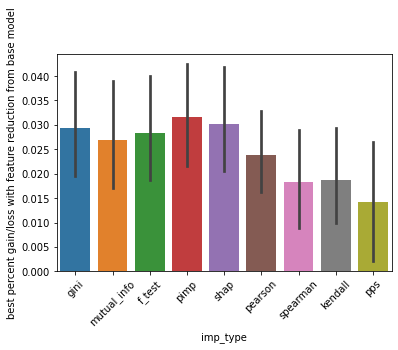

In [36]:
# Case1: Can we get a metric improvement
case_1 = df_res.query('init_mse_test < 1.0'); 
case_1 = case_1[['imp_type','max_perc','random_state', 'data_split']]; 
case_1 = case_1.drop_duplicates();

# plot case_1
plot = sns.barplot(x='imp_type', y='max_perc', ci=95,
            data=case_1
            )
plot.set_xticklabels(plot.get_xticklabels(), rotation=45);
plot.set_ylabel('best percent gain/loss with feature reduction from base model')

Text(0, 0.5, 'percent of features dropped without accuracy loss')

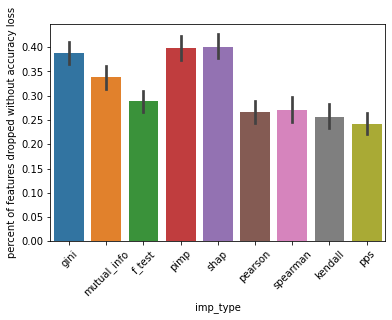

In [37]:
# Case2: No decrease in metric
# % features dropped without performance decrease
case_2 = df_full.query('max_perc == mse_perc')
case_2 = case_2.query('mse_perc >= 0')

case_2['feature_dropped'] =  case_2.max_feature_cnt - case_2.feature_cnt

# 
case_2['feature_dropped_perc'] = (
                                    1 - (case_2.max_feature_cnt - case_2.feature_dropped)
                                      / case_2.max_feature_cnt
                                    )

case_2 = case_2[['imp_type', 'feature_dropped_perc', 'random_state','data_split']]
case_2 = case_2.drop_duplicates()

plot = sns.barplot(x='imp_type', y='feature_dropped_perc',
            data=case_2
            )
plot.set_xticklabels(plot.get_xticklabels(), rotation=45);
plot.set_ylabel('percent of features dropped without accuracy loss')

In [38]:
# Case 3: Maximum interpretability (drop [70%, 80%, 90%] of all features, rounded)

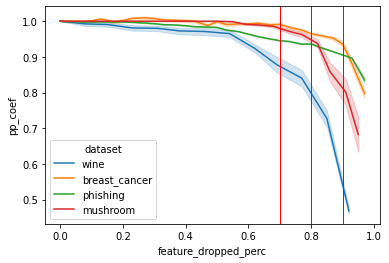

In [39]:
# Let's check out if there is a general pattern of dataset predictive power (pp) coef decrease
# over features dropped percentage

# For most datasets we see a significant decrease at around 80%ish features dropped
# the one exception is boston dataset which seems to drop in predictive power from 30%ish

# choosing to drop 70%, 80%, 90% seems like a reasonable way 
# to find maximally interpretable models that don't sacrifice the metric significantly

case3_1 = df_full[['feature_cnt', 'feature_dropped_perc', 'pp_coef', 'imp_type',
                  'random_state', 'data_split', 'dataset', 'model']]
case3_1 = case3_1.drop_duplicates()
case3_1['feature_dropped_perc'] = case3_1.feature_dropped_perc.round(decimals=2)

case3_1
plot = sns.lineplot(x='feature_dropped_perc', y='pp_coef', hue='dataset', ci=95,
            data=case3_1.query(f'''
        model == "RandomForestClassifier" and \
        imp_type != "pps"
                ''')
            )
plot.axvline(0.7, 0,1, linewidth=1, color='r')
plot.axvline(0.8, 0,1, linewidth=1, color='r')
plot.axvline(0.9, 0,1, linewidth=1, color='r')

In [40]:
sub1 = df_res[df_res.f_cnt_10perc == df_res.feature_cnt]
sub2 = df_res[df_res.f_cnt_20perc == df_res.feature_cnt]
sub3 = df_res[df_res.f_cnt_30perc == df_res.feature_cnt]

In [41]:
case3_2 = pd.concat([sub1, sub2, sub3])

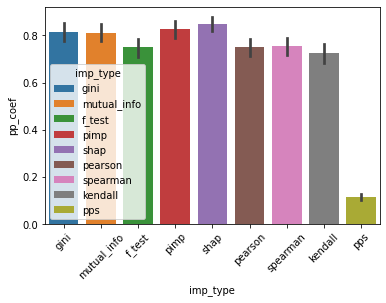

In [42]:
# 90% dropped
plot = sns.barplot(x='imp_type', y='pp_coef', hue='imp_type', ci=95, dodge=False,
            data=sub1
            )
plot.set_xticklabels(plot.get_xticklabels(), rotation=45);

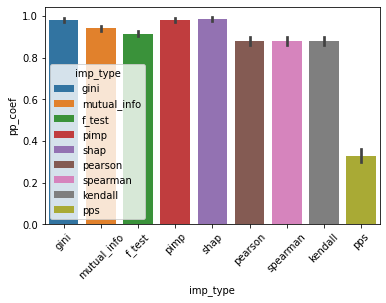

In [43]:
# 80% dropped
plot = sns.barplot(x='imp_type', y='pp_coef', hue='imp_type', ci=95, dodge=False,
            data=sub2
            )
plot.set_xticklabels(plot.get_xticklabels(), rotation=45);

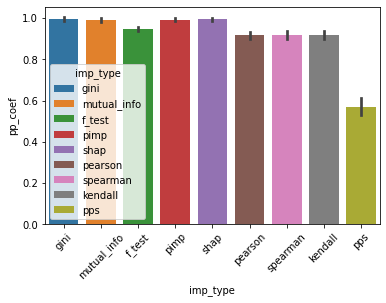

In [44]:
# 70% dropped
plot = sns.barplot(x='imp_type', y='pp_coef', hue='imp_type', ci=95, dodge=False,
            data=sub3
            )
plot.set_xticklabels(plot.get_xticklabels(), rotation=45);

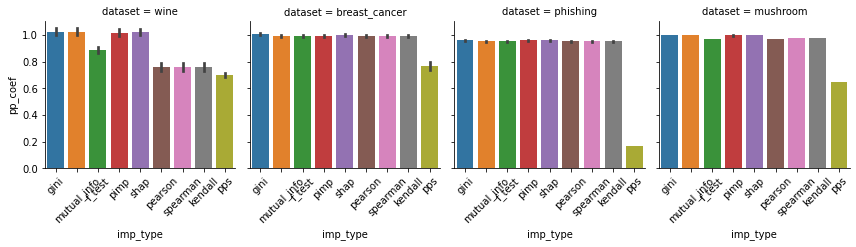

In [45]:
# Since all of the graphs above are aggregate graphs (all datasets together)
# It might be useful to also see the difference between datasets

# maybe turn this into a stacked bar chart stacks = [70%, 80%, 90%], pp_coef
g = sns.FacetGrid(sub3, col='dataset', hue='imp_type')
g.map(sns.barplot,'imp_type', 'pp_coef', ci=95, data=sub3, dodge=False, 
      order=sub3.imp_type.unique().tolist())
g.set_xticklabels(rotation=45)

# 70% dropped

In [46]:
df_full.dataset.unique()

array(['wine', 'breast_cancer', 'phishing', 'mushroom'], dtype=object)

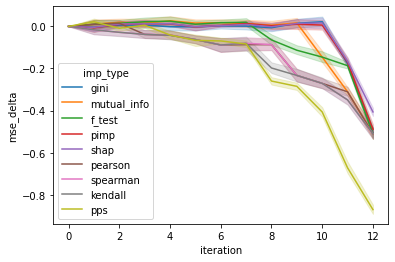

In [47]:
plot = sns.lineplot(x='iteration', y='mse_delta', hue='imp_type', ci=95, err_style='band',
            data=df_full.query(f'dataset == "wine"')
            )